# Guest Journey Pattern Analysis
This notebook contains the Python code, visualizations, and results used for Guest Journey Pattern Analysis in theme parks. It is accompanied by notes and observations to help interpret the findings and understand the patterns behind guest behaviors, preferences, and flow dynamics across different crowd conditions.

This section explores guest behavior and ride preferences across various theme park operating conditions. By segmenting days into quiet days (≤25th percentile), busy days (≥75th percentile), and normal days (25th–75th percentile), we account for fluctuating attendance patterns while explicitly excluding pandemic-era data to ensure accurate benchmarking. Rides are split into ‘family’ or ‘youth’ categories based on correlation strength with a baseline ride (‘Scooby Doo’), with ≥0.5 indicating youth-oriented preferences.
Guests are also labeled based on Express Pass usage, inferred through wait-time thresholds per ride and day type.
We analyze guest ride sequences, wait time tolerance, and movement patterns to uncover insights into how different guest segments — particularly families with children and youth/adult groups — interact with the park. Using techniques like ride correlation clustering, flow movement analysis, Markov modeling, and entropy-based diversity scores.



## Importing Packages and Data Downloads

In [1]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import networkx as nx
from difflib import SequenceMatcher
from itertools import combinations
from scipy.stats import entropy

path = kagglehub.dataset_download("ayushtankha/hackathon")
print("Path to dataset files:", path)

waitingtimes_path = os.path.join(path, "waiting_times.csv")
waiting_times_df = pd.read_csv(waitingtimes_path)

parkattr_path = os.path.join(path, "link_attraction_park.csv")
parkattr_df = pd.read_csv(parkattr_path)

attendace_path = os.path.join(path, "attendance.csv")
attendance_df = pd.read_csv(attendace_path)

Path to dataset files: /Users/cheryllfidelia/.cache/kagglehub/datasets/ayushtankha/hackathon/versions/1


## Data Cleaning and Preprocessing
This project uses anonymized theme park visit data from Kaggle's hackathon dataset to simulate and model common guest behaviors across theme parks.

In [2]:
# FORMATTING THE DATA
# (1) Turn the deb_time into datetime objects and remove seconds (they are all 0)
waiting_times_df['DEB_TIME'] = pd.to_datetime(waiting_times_df['DEB_TIME'])
waiting_times_df['DEB_TIME'] = waiting_times_df['DEB_TIME'].dt.strftime('%H:%M')

# (2) Turn guest_carried into integers + round off capacity and adjust capacity to their nearest integers
waiting_times_df['GUEST_CARRIED'] = waiting_times_df['GUEST_CARRIED'].astype(int)
waiting_times_df['CAPACITY'] = waiting_times_df['CAPACITY'].round().astype(int)
waiting_times_df['ADJUST_CAPACITY'] = waiting_times_df['ADJUST_CAPACITY'].round().astype(int)

# (3) Sorting based on the date and time of debarkation
waiting_times_df = waiting_times_df.sort_values(['WORK_DATE', 'DEB_TIME'])

# Filter out data where rides were not operational
waitingtimes_oper = waiting_times_df[
    (waiting_times_df['GUEST_CARRIED'] != 0) & 
    (waiting_times_df['CAPACITY'] != 0)
]

waitingtimes_oper = waitingtimes_oper.sort_values(['WORK_DATE', 'DEB_TIME', 'WAIT_TIME_MAX'], ascending=[True, True, False])
waitingtimes_oper = waitingtimes_oper.drop(columns=['DEB_TIME_HOUR', 'FIN_TIME', 'NB_UNITS', 'OPEN_TIME', 'UP_TIME', 
                                                    'NB_MAX_UNIT', 'DOWNTIME', 'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY'])

# Merge with link_attraction_park.csv
parkattr_df[['ATTRACTION', 'PARK']] = parkattr_df['ATTRACTION;PARK'].str.split(";", expand=True)
parkattr_df = parkattr_df.drop(columns=['ATTRACTION;PARK'])
merged_df = pd.merge(waitingtimes_oper, parkattr_df, left_on='ENTITY_DESCRIPTION_SHORT', right_on='ATTRACTION', how='inner')
merged_df = merged_df.drop(columns=['ENTITY_DESCRIPTION_SHORT'])

# Filter for Tivoli Gardens
tivoli_g = merged_df[merged_df['PARK'] == 'Tivoli Gardens']
tivoli_g = tivoli_g.copy() 
tivoli_g['WORK_DATE'] = pd.to_datetime(tivoli_g['WORK_DATE'])
tivoli_g['TIMESTAMP'] = pd.to_datetime(tivoli_g['WORK_DATE'].astype(str) + ' ' + tivoli_g['DEB_TIME'])

# Finding COVID dates
attendance_df['USAGE_DATE'] = pd.to_datetime(attendance_df['USAGE_DATE'])
covid = attendance_df[(attendance_df['USAGE_DATE'] >= '2020-03-01') & (attendance_df['USAGE_DATE'] <= '2021-08-01')]

negative_att = attendance_df[attendance_df['attendance'] < 0]

## Defining Functions for Analysis


In [3]:
def label_express_pass_by_daytype( df, threshold=0.3): 
    thresholds = df.groupby(['ATTRACTION', 'DAY_TYPE'])['WAIT_TIME_MAX'].quantile(threshold).to_dict()
    
    def is_express(row):
        key = (row['ATTRACTION'], row['DAY_TYPE'])
        return row['WAIT_TIME_MAX'] < thresholds.get(key, np.inf)
    
    df['EXPRESS_PASS'] = df.apply(is_express, axis=1)
    return df

def determine_day_types(attendance_df, covid, facility_name='Tivoli Gardens'):
    tivoli_attendance_df = attendance_df[attendance_df['FACILITY_NAME'] == facility_name]
    daily_attendance = tivoli_attendance_df.groupby(tivoli_attendance_df['USAGE_DATE'].dt.date)['attendance'].sum()

    busy_threshold = daily_attendance.quantile(0.75)
    quiet_threshold = daily_attendance.quantile(0.25)

    busy_days = daily_attendance[daily_attendance > busy_threshold].index
    quiet_days = daily_attendance[daily_attendance < quiet_threshold].index
    covid_dates = covid['USAGE_DATE'].drop_duplicates().dt.date
    return busy_days, quiet_days, covid_dates

def tag_day_type(df, covid_dates, busy_days, quiet_days):
    df = df.copy()
    df.loc[:, 'DAY_TYPE'] = 'normal'
    df.loc[df['WORK_DATE'].isin(covid_dates), 'DAY_TYPE'] = 'covid'
    df.loc[df['WORK_DATE'].isin(covid_dates), 'DAY_TYPE'] = 'covid'
    df.loc[df['WORK_DATE'].isin(busy_days), 'DAY_TYPE'] = 'busy'
    df.loc[df['WORK_DATE'].isin(quiet_days), 'DAY_TYPE'] = 'quiet'
    return df


def simulate_guest_sequences(df, time_gap_seconds=1800):
    df = df.sort_values(by='TIMESTAMP')
    df['GAP'] = df['TIMESTAMP'].diff().dt.total_seconds().fillna(0) #Time gaps in seconds
    df['GUEST_ID'] = (df['GAP'] > time_gap_seconds).cumsum() #If time gap > 30 mins, assign new guest ID
    guest_sequences = df.groupby('GUEST_ID')['ATTRACTION'].apply(list) #Getting the ride sequence per guest
    express_map = df.groupby('GUEST_ID')['EXPRESS_PASS'].mean().apply(lambda x: x > 0.6) #if >50% rides are fast, guest = express pass
    return guest_sequences, express_map

def label_guest_sequences_as_express(df, guest_sequences, threshold=0.25):
    thresholds = df.groupby(['ATTRACTION', 'DAY_TYPE'])['WAIT_TIME_MAX'].quantile(threshold).to_dict()
    
    guest_labels = {}
    for guest_id, sequence in guest_sequences.items():
        guest_df = df[df['GUEST_ID'] == guest_id]
        if guest_df.empty:
            guest_labels[guest_id] = False
            continue

        low_wait_count = 0
        for _, row in guest_df.iterrows():
            key = (row['ATTRACTION'], row['DAY_TYPE'])
            ride_threshold = thresholds.get(key, np.inf)
            if row['WAIT_TIME_MAX'] < ride_threshold:
                low_wait_count += 1

        express_ratio = low_wait_count / len(guest_df)
        guest_labels[guest_id] = express_ratio > 0.6  # Consider express if >60% rides were below wait threshold
    return pd.Series(guest_labels)

    
def label_guest_by_ridetype(sequences, family_rides, youth_rides): 
    guest_types = {}
    for guest_id, seq in sequences.items():
        fam_count = sum(1 for ride in seq if ride in family_rides)
        youth_count = sum(1 for ride in seq if ride in youth_rides)
        if fam_count > youth_count:
            guest_types[guest_id] = "Family"
        elif youth_count > fam_count:
            guest_types[guest_id] = "Youth"
        else:
            guest_types[guest_id] = "Mixed"
    return pd.Series(guest_types)
    

def generate_guest_summary(df, reference_ride="Scooby Doo", gap_seconds=1800):
    #Simulate guest sequences
    sequences, _ = simulate_guest_sequences(df, time_gap_seconds=gap_seconds)

    #Reassign guest ID on main df
    df = df.sort_values(by='TIMESTAMP')
    df['GAP'] = df['TIMESTAMP'].diff().dt.total_seconds().fillna(0)
    df['GUEST_ID'] = (df['GAP'] > gap_seconds).cumsum()

    #Label express pass guests
    guest_express_labels = label_guest_sequences_as_express(df, sequences)

    #Segment ride types
    family_rides, youth_rides = family_rides, youth_rides = analyze_ride_correlations(df, reference_ride=reference_ride, day_type=None)
    guest_ride_types = label_guest_by_ridetype(sequences, family_rides, youth_rides)

    #Build guest summary df
    guest_summary = pd.DataFrame({
        'GUEST_ID': sequences.index,
        'RIDE_SEQUENCE': sequences.values,
        'EXPRESS_PASS': guest_express_labels,
        'RIDE_TYPE': guest_ride_types
    })

    #Assign day type per guest
    guest_daytypes = df.groupby('GUEST_ID')['DAY_TYPE'].first()
    guest_summary['DAY_TYPE'] = guest_summary['GUEST_ID'].map(guest_daytypes)

    return guest_summary

def plot_median_wait_times(df, day_type=None, title_suffix=""): 
    #plotting waiting times line chart
    if day_type:
        df = df[df['DAY_TYPE'] == day_type]
        title_suffix = f"({day_type.title()} Days)"

    median_wait_times = df.groupby(['DEB_TIME', 'ATTRACTION'])['WAIT_TIME_MAX'].median().unstack()

    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap('tab20', len(median_wait_times.columns))

    for i, attraction in enumerate(median_wait_times.columns):
        plt.plot(median_wait_times.index, median_wait_times[attraction],
                label=attraction, color=colors(i), marker='o', markersize=4)

    plt.xlabel('Time of Day')
    plt.ylabel('Median Waiting Time (minutes)')
    plt.title(f'Median Waiting Time Throughout the Day {title_suffix} - Tivoli Gardens')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(median_wait_times.index[::4], rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_ride_correlation_heatmap(df, day_type=None, title_suffix=""):
    #plotting correlations between rides heatmap
    if day_type:
        df = df[df['DAY_TYPE'] == day_type]
        title_suffix = f"({day_type.title()} Days)"

    tivoli_pivot = df.pivot(index='TIMESTAMP', columns='ATTRACTION', values='WAIT_TIME_MAX')
    correlation_matrix = tivoli_pivot.corr()

    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Between Ride Waiting Times {title_suffix}")
    plt.tight_layout()
    plt.show()

def analyze_ride_correlations(df, reference_ride="", day_type=""):
    #ride correlations using the date type
    if day_type:
        df = df[df['DAY_TYPE'] == day_type]

    tivoli_pivot = df.pivot(index='TIMESTAMP', columns='ATTRACTION', values='WAIT_TIME_MAX')
    correlation_matrix = tivoli_pivot.corr()

    # Correlation with the reference ride
    reference_correlations = correlation_matrix[reference_ride]

    # Segment rides
    family_rides = [ride for ride, corr in reference_correlations.items() if corr < 0.5]
    youth_rides = [ride for ride, corr in reference_correlations.items() if corr >= 0.5]

    return family_rides, youth_rides

def analyze_guest_movement(df, reference_ride=None, day_type=None):
    if day_type:
        df = df[df['DAY_TYPE'] == day_type]

    # Pivot ride wait times
    tivoli_pivot = df.pivot(index='TIMESTAMP', columns='ATTRACTION', values='WAIT_TIME_MAX')

    if day_type == 'covid':
        # Skip segmentation: analyze all ride movements together
        ride_changes = tivoli_pivot.diff()

        movement_counts = []
        for from_ride in ride_changes.columns:
            for to_ride in ride_changes.columns:
                if from_ride != to_ride:
                    movement = ((ride_changes[from_ride] < 0) & (ride_changes[to_ride] > 0)).sum()
                    movement_counts.append({"from": from_ride, "to": to_ride, "count": movement})

        all_movements = pd.DataFrame(movement_counts)
        return all_movements, None

    # Non-covid days requires a reference_ride (dividing between family and youth)
    if not reference_ride:
        raise ValueError("You must provide a reference_ride for non-covid day types.")

    # Segmenting using correlation
    correlation_matrix = tivoli_pivot.corr()
    reference_correlations = correlation_matrix[reference_ride]

    family_rides = [ride for ride, corr in reference_correlations.items() if corr < 0.5]
    youth_rides = [ride for ride, corr in reference_correlations.items() if corr >= 0.5]

    # Family
    family_pivot = tivoli_pivot[family_rides]
    family_changes = family_pivot - family_pivot.shift(1)

    family_movement_counts = []
    for from_ride in family_changes.columns:
        for to_ride in family_changes.columns:
            if from_ride != to_ride:
                movement = ((family_changes[from_ride] < 0) & (family_changes[to_ride] > 0)).sum()
                family_movement_counts.append({"from": from_ride, "to": to_ride, "count": movement})
    fam_movements = pd.DataFrame(family_movement_counts)

    # Youth
    youth_pivot = tivoli_pivot[youth_rides]
    youth_changes = youth_pivot - youth_pivot.shift(1)

    youth_movement_counts = []
    for from_ride in youth_changes.columns:
        for to_ride in youth_changes.columns:
            if from_ride != to_ride:
                movement = ((youth_changes[from_ride] < 0) & (youth_changes[to_ride] > 0)).sum()
                youth_movement_counts.append({"from": from_ride, "to": to_ride, "count": movement})
    youth_movements = pd.DataFrame(youth_movement_counts)

    return fam_movements, youth_movements

def markov_chain_analysis(df, title):
    graph = nx.DiGraph()
    for _, row in df.iterrows():
        graph.add_edge(row['from'], row['to'], weight=row['count']) #transition edeges

    rides = list(graph.nodes())
    transition_matrix = np.zeros((len(rides), len(rides)))

    for i, from_ride in enumerate(rides):
        total_outflow = sum(graph.get_edge_data(from_ride, to_ride)['weight'] for to_ride in graph.successors(from_ride))
        if total_outflow > 0:
            for j, to_ride in enumerate(rides):
                if graph.has_edge(from_ride, to_ride):
                    transition_matrix[i, j] = graph.get_edge_data(from_ride, to_ride)['weight'] / total_outflow

    #Compute steady state distribution:
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    steady_state = np.abs(eigenvectors[:, np.argmax(eigenvalues)])
    steady_state /= steady_state.sum()

    steady_state_distribution = pd.Series(steady_state, index=rides)

    print(f"\n{title} - Steady-State Distribution:")
    print(steady_state_distribution)

def guest_avg_wait_top_rides(df, target_rides):
    df = df[df['ATTRACTION'].isin(target_rides)] #Focus on top rides!
    df = df.sort_values(by='TIMESTAMP')
    df['GAP'] = df['TIMESTAMP'].diff().dt.total_seconds().fillna(0)
    df['GUEST_ID'] = (df['GAP'] > 1800).cumsum() #Segmenting guests by time gaps
    avg_wait = df.groupby(['GUEST_ID', 'DAY_TYPE'])['WAIT_TIME_MAX'].mean().reset_index()
    avg_wait = avg_wait.rename(columns={'WAIT_TIME_MAX': 'AVG_WAIT_TIME_TOP_3'})
    return avg_wait

def calculate_outflow_for_top_rides(df, top_rides, reference_ride="Scooby Doo"):
    outflow_summary = []

    for day_type in df['DAY_TYPE'].unique():
        if day_type == "covid":
            #Depending on DAY_TYPE, since covid doesnt need a reference_ride for division of youth v family with children
            movement_df, _ = analyze_guest_movement(df, day_type=day_type)
        else:
            movement_df, _ = analyze_guest_movement(df, reference_ride=reference_ride, day_type=day_type)

        outflow = movement_df.groupby('from')['count'].sum()
        filtered_outflow = outflow[outflow.index.isin(top_rides)]
        avg_outflow = filtered_outflow.mean()

        outflow_summary.append({
            'DAY_TYPE': day_type,
            'AVG_OUTFLOW_TOP_3': avg_outflow
        })

    return pd.DataFrame(outflow_summary)

def plot_combined_wait_and_outflow(wait_df, outflow_df):
    combined = wait_df.groupby('DAY_TYPE')['AVG_WAIT_TIME_TOP_3'].mean().reset_index()
    combined = combined.merge(outflow_df, on='DAY_TYPE')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    #Left Y-Axis = Average Wait Time (line)
    ax1.set_ylabel('Avg Wait Time (mins)', color='blue')
    sns.lineplot(data=combined, x='DAY_TYPE', y='AVG_WAIT_TIME_TOP_3', marker='o', ax=ax1, color='blue', label='Avg Wait Time')
    ax1.tick_params(axis='y', labelcolor='blue')

    #Right y-axis = Guest Outflow (bar)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Avg Guest Outflow (top 3 rides)', color='red')
    sns.barplot(data=combined, x='DAY_TYPE', y='AVG_OUTFLOW_TOP_3', ax=ax2, alpha=0.3, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Guest Willingness to Wait vs Ride Popularity (Top 3 Rides)')
    plt.tight_layout()
    plt.show()

def plot_avg_wait_boxplot(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='DAY_TYPE', y='AVG_WAIT_TIME_TOP_3', palette='Set2')
    sns.stripplot(data=df, x='DAY_TYPE', y='AVG_WAIT_TIME_TOP_3', color='black', size=3, alpha=0.3, jitter=0.2)

    plt.title("Guest Wait Time Tolerance for Top 3 Rides (Boxplot)")
    plt.xlabel("Day Type")
    plt.ylabel("Avg Wait Time per Guest (Top 3 Rides) [mins]")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def sequence_similarity(seq1, seq2):
    return SequenceMatcher(None, seq1, seq2).ratio() #Similarity score between sequences

def average_similarity(sequences):
    combos = list(combinations(sequences, 2)) #Pairwise combinations
    if not combos:
        return 0
    return np.mean([sequence_similarity(a, b) for a, b in combos]) #Average similarities across all pairs

def compute_sequence_entropy(seq):
    counts = pd.Series(seq).value_counts(normalize=True) #Frequency Distribution
    return entropy(counts)

In [4]:
busy_days, quiet_days, covid_dates = determine_day_types(attendance_df, covid)
tivoli_g = tag_day_type(tivoli_g, covid_dates, busy_days, quiet_days)
tivoli_g = label_express_pass_by_daytype(tivoli_g)

## Analysis
### 1. Normal Days 

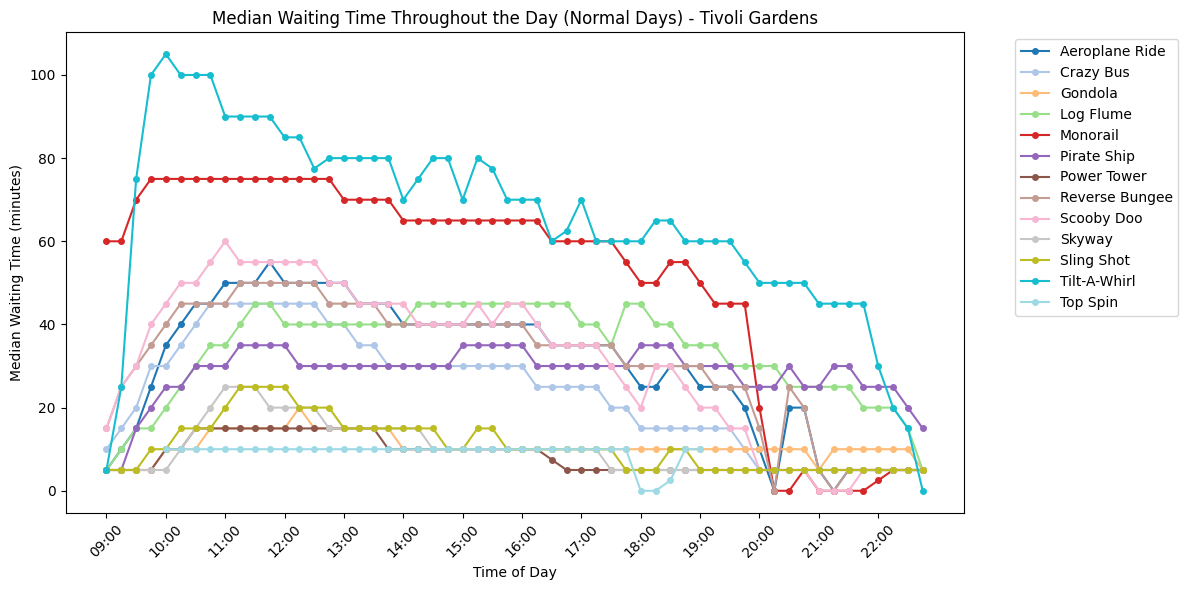

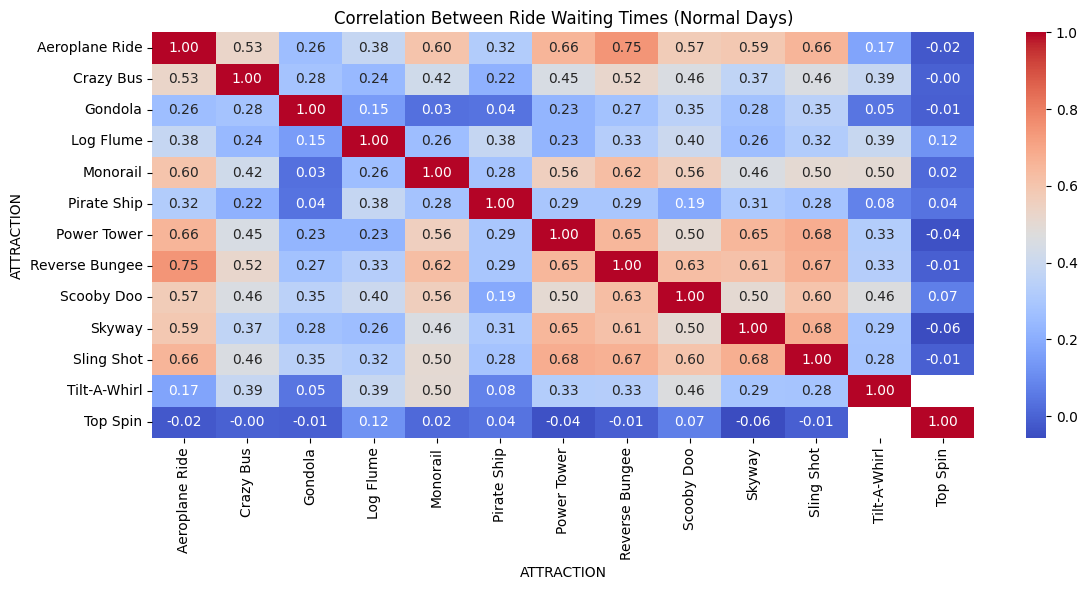

In [5]:

# Plotting line graphs and correlation heatmaps for each to view 
plot_median_wait_times(tivoli_g, day_type="normal", title_suffix="Normal Days")
plot_ride_correlation_heatmap(tivoli_g, day_type="normal", title_suffix="Normal Days")

The first figure shows how ride wait times vary during normal days amongst the different attractions. The second figure, on the other hand,shows the correlation between rides based on wait-time and outflow on normal days. This correlation will be used to segment guests by purpose of visit (i.e youths who come for social functions and families with children). The Scooby Doo ride will be used as a baseline for this segmentation due to its seen common correlation to most of the rides.

In [6]:
# Segmenting of Guests -- Family w/ Kids vs. Youths
family_rides, youth_rides = analyze_ride_correlations(tivoli_g, day_type='normal', reference_ride="Scooby Doo")
# Potential movements from and to rides
fam_movements, youth_movements = analyze_guest_movement(tivoli_g, reference_ride='Scooby Doo', day_type="normal")

# Normal Days
family_outflow = fam_movements.groupby('from')['count'].sum().sort_values(ascending=False)
print("Family Rides - Highest Outgoing Traffic:")
print(family_outflow)
print("\nFamily Rides - Most Frequent Transitions:")
print(fam_movements.sort_values(by='count', ascending=False))
markov_chain_analysis(fam_movements, "Family Rides")

youth_outflow = youth_movements.groupby('from')['count'].sum().sort_values(ascending=False)
print("\nYouth Rides - Highest Outgoing Traffic:")
print(youth_outflow)
print("\nYouth Rides - Most Frequent Transitions:")
print(youth_movements.sort_values(by='count', ascending=False))
markov_chain_analysis(youth_movements, "Youth Rides")

Family Rides - Highest Outgoing Traffic:
from
Crazy Bus       2873
Log Flume       2042
Pirate Ship     1530
Gondola         1186
Tilt-A-Whirl     228
Top Spin          20
Name: count, dtype: int64

Family Rides - Most Frequent Transitions:
            from            to  count
1      Crazy Bus     Log Flume   1542
10     Log Flume     Crazy Bus   1017
2      Crazy Bus   Pirate Ship    857
17   Pirate Ship     Log Flume    638
12     Log Flume   Pirate Ship    627
15   Pirate Ship     Crazy Bus    597
6        Gondola     Log Flume    489
0      Crazy Bus       Gondola    424
5        Gondola     Crazy Bus    382
11     Log Flume       Gondola    352
7        Gondola   Pirate Ship    291
16   Pirate Ship       Gondola    250
23  Tilt-A-Whirl   Pirate Ship     76
20  Tilt-A-Whirl     Crazy Bus     63
22  Tilt-A-Whirl     Log Flume     62
3      Crazy Bus  Tilt-A-Whirl     40
13     Log Flume  Tilt-A-Whirl     39
18   Pirate Ship  Tilt-A-Whirl     38
21  Tilt-A-Whirl       Gondola     27

Family rides show higher outgoing traffic, meaning guests move frequently from these rides to others—likely because family groups cover more attractions in one visit. The Markov chain analysis helps visualize these transitions, showing which rides are common starting points or hubs for family journeys.

Youth rides, meanwhile, have fewer but more intense transitions—guests move between a smaller set of high-thrill rides. The Markov analysis highlights strong preferences and repeated movement patterns among youth visitors, suggesting more targeted ride behavior compared to family groups.

In short, family guests explore broadly, while youth guests loop between thrill rides more tightly.








### Busy Days 

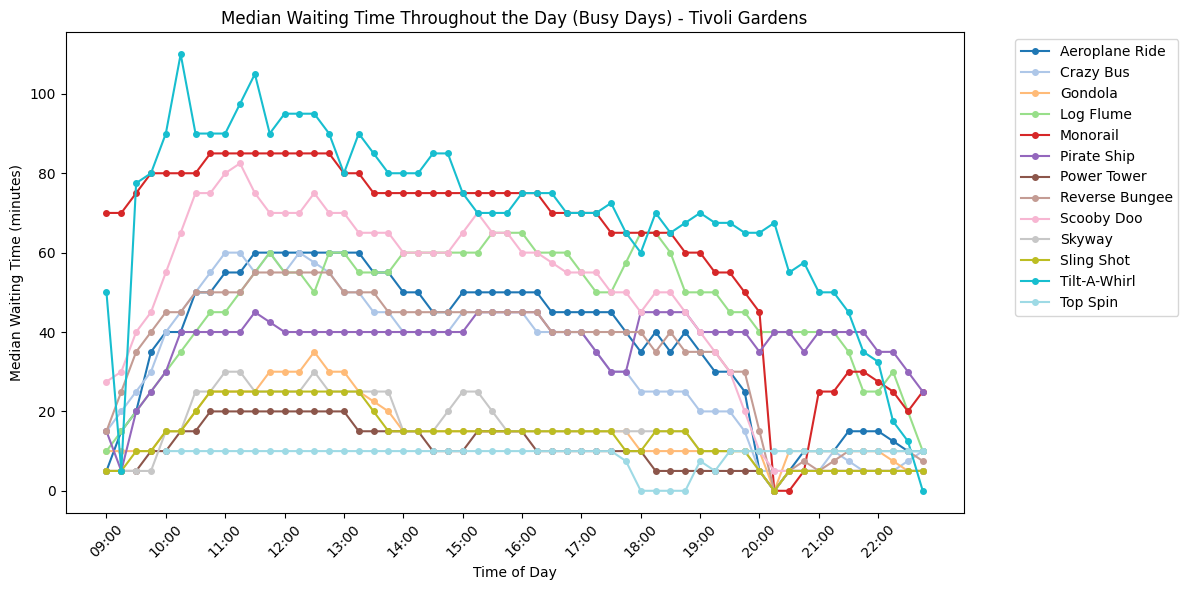

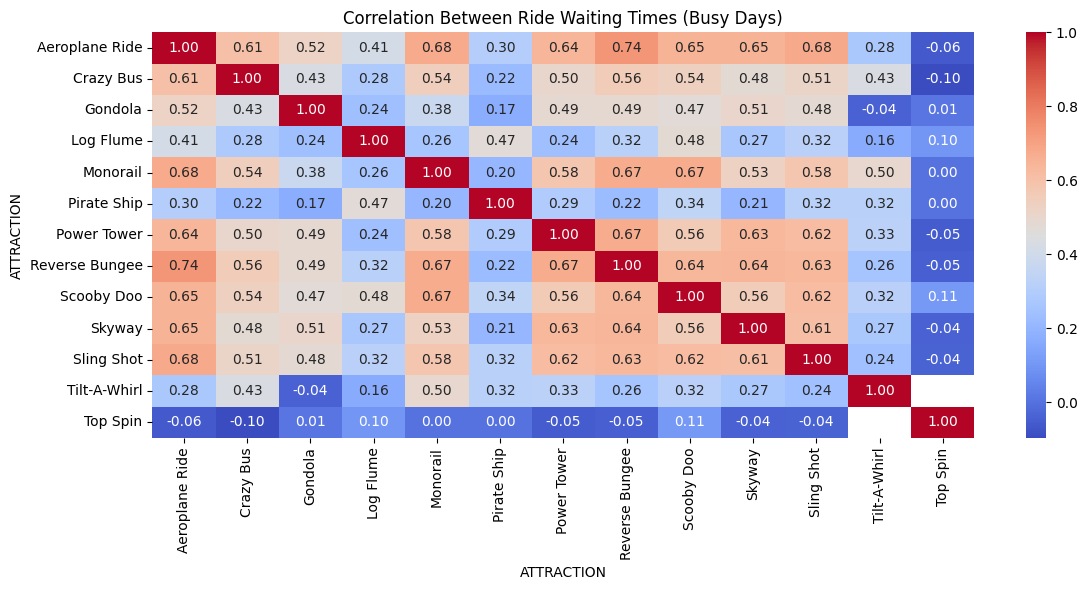

In [7]:
plot_median_wait_times(tivoli_g, day_type="busy", title_suffix="Busy Days")
plot_ride_correlation_heatmap(tivoli_g, day_type="busy", title_suffix="Busy Days")

The first figure shows how ride wait times vary during busy days amongst the different attractions. The second figure, on the other hand,shows the correlation between rides based on wait-time and outflow on busy days. This correlation will be used to segment guests by purpose of visit (i.e youths who come for social functions and families with children). The Scooby Doo ride will be used as a baseline for this segmentation due to its seen common correlation to most of the rides.

In [8]:
family_rides_busy, youth_rides_busy = analyze_ride_correlations(tivoli_g, day_type='busy', reference_ride="Scooby Doo")

fam_movements_busy, youth_movements_busy = analyze_guest_movement(tivoli_g, reference_ride='Scooby Doo', day_type="busy")

family_outflow_busy = fam_movements_busy.groupby('from')['count'].sum().sort_values(ascending=False)
print("Family Rides during Busy Days - Highest Outgoing Traffic:")
print(family_outflow_busy)
print("\nFamily Rides during Busy Days - Most Frequent Transitions:")
print(fam_movements_busy.sort_values(by='count', ascending=False))
markov_chain_analysis(fam_movements_busy, "Family Rides during Busy Days")

youth_outflow_busy = youth_movements_busy.groupby('from')['count'].sum().sort_values(ascending=False)
print("\nYouth Rides during Busy Days - Highest Outgoing Traffic:")
print(youth_outflow_busy)
print("\nYouth Rides during Busy Days - Most Frequent Transitions:")
print(youth_movements_busy.sort_values(by='count', ascending=False))
markov_chain_analysis(youth_movements_busy, "Youth Rides during Busy Days")

Family Rides during Busy Days - Highest Outgoing Traffic:
from
Gondola         361
Log Flume       320
Pirate Ship     288
Tilt-A-Whirl     30
Top Spin          3
Name: count, dtype: int64

Family Rides during Busy Days - Most Frequent Transitions:
            from            to  count
0        Gondola     Log Flume    257
9    Pirate Ship     Log Flume    201
4      Log Flume       Gondola    163
5      Log Flume   Pirate Ship    141
1        Gondola   Pirate Ship     99
8    Pirate Ship       Gondola     75
13  Tilt-A-Whirl     Log Flume     16
6      Log Flume  Tilt-A-Whirl     11
14  Tilt-A-Whirl   Pirate Ship     10
10   Pirate Ship  Tilt-A-Whirl     10
7      Log Flume      Top Spin      5
12  Tilt-A-Whirl       Gondola      4
2        Gondola  Tilt-A-Whirl      4
11   Pirate Ship      Top Spin      2
17      Top Spin     Log Flume      2
3        Gondola      Top Spin      1
16      Top Spin       Gondola      1
15  Tilt-A-Whirl      Top Spin      0
18      Top Spin   Pirate Shi

On busy days, both family and youth segments display noticeable shifts in ride transition behavior due to crowding and longer wait times.

For family rides, the highest outgoing traffic is more evenly distributed compared to normal days, suggesting that families adapt their paths to avoid congestion. The Markov chain reveals more dispersed transitions, indicating less predictable patterns—likely due to families seeking shorter queues or easier rides for children.

For youth rides, the transitions are still focused but show more loops and repeated transitions, possibly because youths are willing to wait longer or revisit their favorite thrill rides despite the crowds. The Markov structure still highlights strong pathways, though they're slightly less concentrated than on normal days.






### Quiet Days 

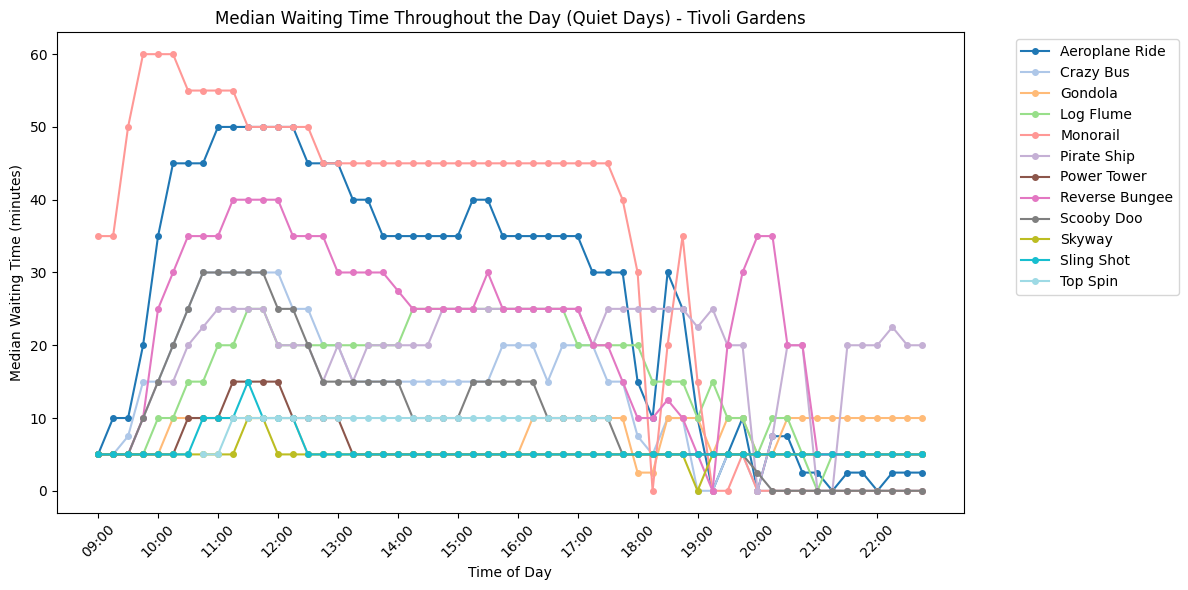

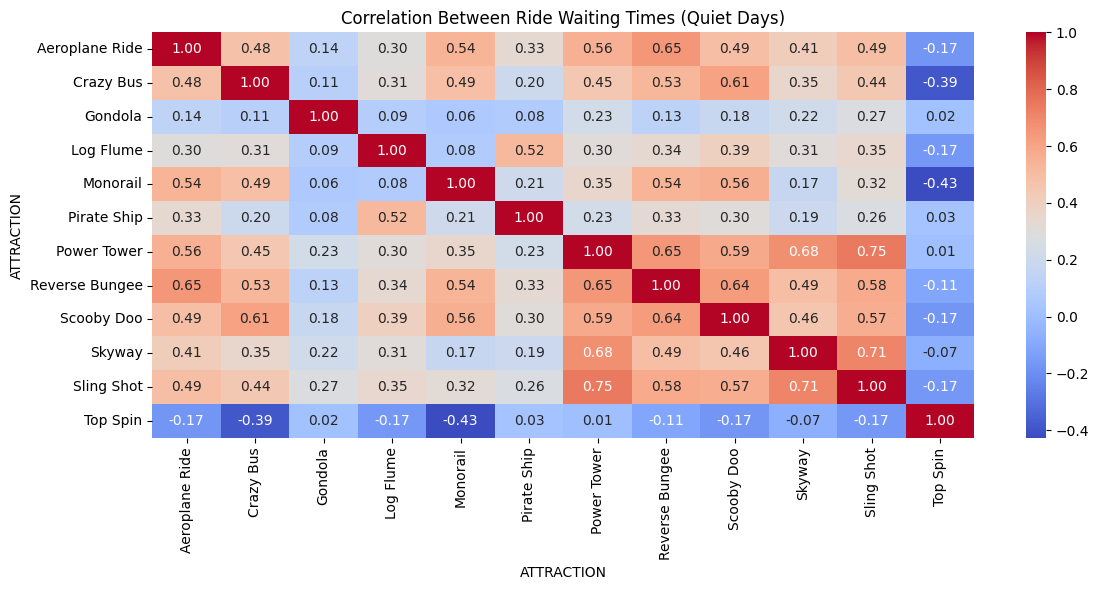

In [9]:
plot_median_wait_times(tivoli_g, day_type="quiet", title_suffix="Quiet Days")
plot_ride_correlation_heatmap(tivoli_g, day_type="quiet", title_suffix="Quiet Days")

The first figure shows how ride wait times vary during quiet days amongst the different attractions. The second figure, on the other hand, shows the correlation between rides based on wait-time and outflow on quiet days. This correlation will be used to segment guests by purpose of visit (i.e youths who come for social functions and families with children). The Scooby Doo ride will be used as a baseline for this segmentation due to its seen common correlation to most of the rides.

In [10]:
family_rides_quiet, youth_rides_quiet = analyze_ride_correlations(tivoli_g, day_type='quiet', reference_ride="Scooby Doo")

fam_movements_quiet, youth_movements_quiet = analyze_guest_movement(tivoli_g, reference_ride='Scooby Doo', day_type="quiet")

# Quiet Days
family_outflow_quiet = fam_movements_quiet.groupby('from')['count'].sum().sort_values(ascending=False)
print("Family Rides during Quiet Days - Highest Outgoing Traffic:")
print(family_outflow_quiet)
print("\nFamily Rides during Quiet Days - Most Frequent Transitions:")
print(fam_movements_quiet.sort_values(by='count', ascending=False))
markov_chain_analysis(fam_movements_quiet, "Family Rides during Quiet Days")

youth_outflow_quiet = youth_movements_quiet.groupby('from')['count'].sum().sort_values(ascending=False)
print("\nYouth Rides during Quiet Days - Highest Outgoing Traffic:")
print(youth_outflow_quiet)
print("\nYouth Rides during Quiet Days - Most Frequent Transitions:")
print(youth_movements_quiet.sort_values(by='count', ascending=False))
markov_chain_analysis(youth_movements_quiet, "Youth Rides during Quiet Days")


Family Rides during Quiet Days - Highest Outgoing Traffic:
from
Aeroplane Ride    742
Pirate Ship       486
Log Flume         434
Skyway            236
Gondola           183
Top Spin            0
Name: count, dtype: int64

Family Rides during Quiet Days - Most Frequent Transitions:
              from              to  count
2   Aeroplane Ride     Pirate Ship    362
15     Pirate Ship  Aeroplane Ride    244
1   Aeroplane Ride       Log Flume    230
12       Log Flume     Pirate Ship    164
10       Log Flume  Aeroplane Ride    162
17     Pirate Ship       Log Flume    129
23          Skyway     Pirate Ship     75
0   Aeroplane Ride         Gondola     75
3   Aeroplane Ride          Skyway     74
22          Skyway       Log Flume     74
6          Gondola       Log Flume     69
20          Skyway  Aeroplane Ride     69
18     Pirate Ship          Skyway     62
11       Log Flume         Gondola     62
16     Pirate Ship         Gondola     51
5          Gondola  Aeroplane Ride     48
13 

On quiet days, family guests most frequently transitioned between Aeroplane Ride, Pirate Ship, and Log Flume, with these three making up the majority of outgoing traffic and steady-state presence. Movements between these rides were balanced and consistent, reflecting a relaxed guest flow without excessive congestion.

For youth guests, Monorail, Scooby Doo, and Crazy Bus were the dominant rides in terms of transitions and popularity. The steady-state distribution shows relatively equal preference for a range of thrill rides, but transitions like Monorail → Crazy Bus and Scooby Doo → Reverse Bungee indicate smoother flows possibly due to lower wait times and shorter queues on quiet days.

### Pandemic (Covid-19) Days
This day is not segmented into youths and family with children due to the low correlations between most rides.

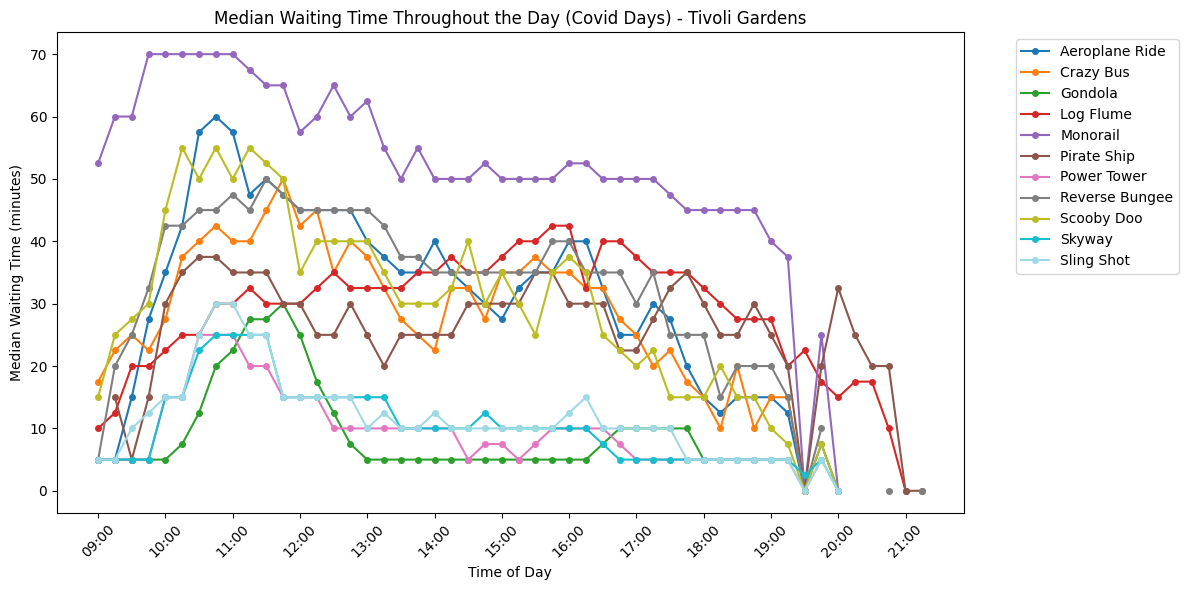

In [11]:
plot_median_wait_times(tivoli_g, day_type="covid", title_suffix="COVID Days")

The figure above shows how ride wait times vary during days of the covid-19 pandemic amongst the different attractions. 

In [12]:
movement_covid, _ = analyze_guest_movement(tivoli_g, day_type="covid")

covid_outflow = movement_covid.groupby('from')['count'].sum().sort_values(ascending=False)
print("Rides during Covid Days - Highest Outgoing Traffic:")
print(covid_outflow)
print("\nRides during Covid Days - Most Frequent Transitions:")
print(movement_covid.sort_values(by='count', ascending=False))
markov_chain_analysis(movement_covid, "Rides during Covid Days")

Rides during Covid Days - Highest Outgoing Traffic:
from
Crazy Bus         182
Scooby Doo        176
Aeroplane Ride    159
Monorail          158
Pirate Ship       125
Reverse Bungee    119
Skyway            108
Sling Shot         98
Power Tower        91
Log Flume          33
Gondola            21
Name: count, dtype: int64

Rides during Covid Days - Most Frequent Transitions:
              from              to  count
80      Scooby Doo  Aeroplane Ride     33
17       Crazy Bus      Scooby Doo     33
81      Scooby Doo       Crazy Bus     29
3   Aeroplane Ride        Monorail     27
10       Crazy Bus  Aeroplane Ride     27
..             ...             ...    ...
62     Power Tower         Gondola      1
92          Skyway         Gondola      0
25         Gondola     Power Tower      0
32       Log Flume         Gondola      0
35       Log Flume     Power Tower      0

[110 rows x 3 columns]

Rides during Covid Days - Steady-State Distribution:
Aeroplane Ride    0.123193
Crazy Bus   

During COVID-19 days, guest flow was notably more dispersed and subdued, reflecting lower attendance and reduced ride activity. While Crazy Bus, Scooby Doo, and Aeroplane Ride (the top three rides) remained popular, their transition counts were significantly lower compared to normal or busy periods. The most frequent transitions were scattered with lower volumes, suggesting shorter, less predictable guest journeys. The steady-state distribution shows a relatively flat spread across several attractions, indicating no strong ride dominance—likely a result of operational changes or social distancing measures affecting normal guest behavior.

### Wait-Time Tolerance

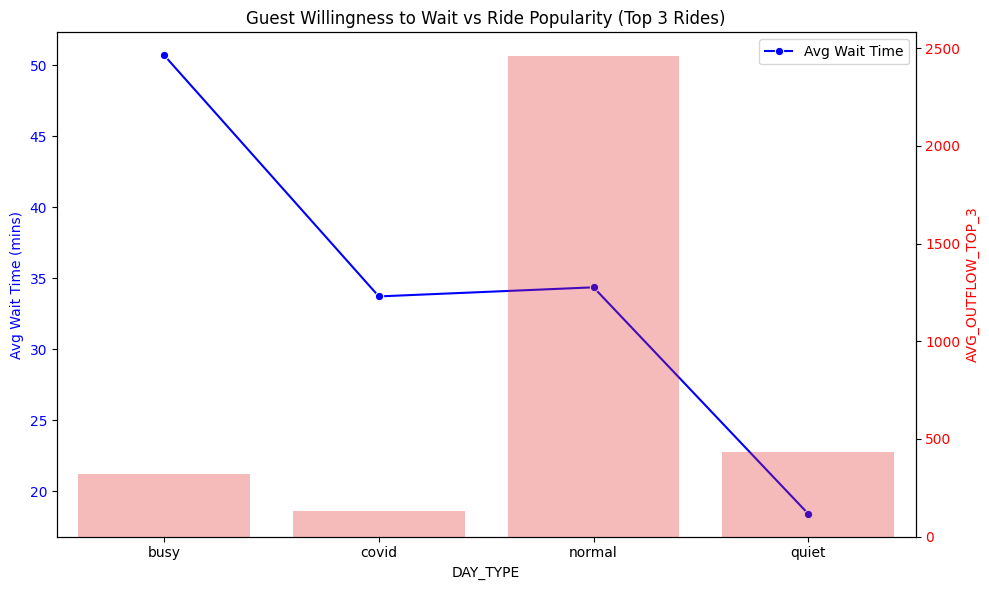

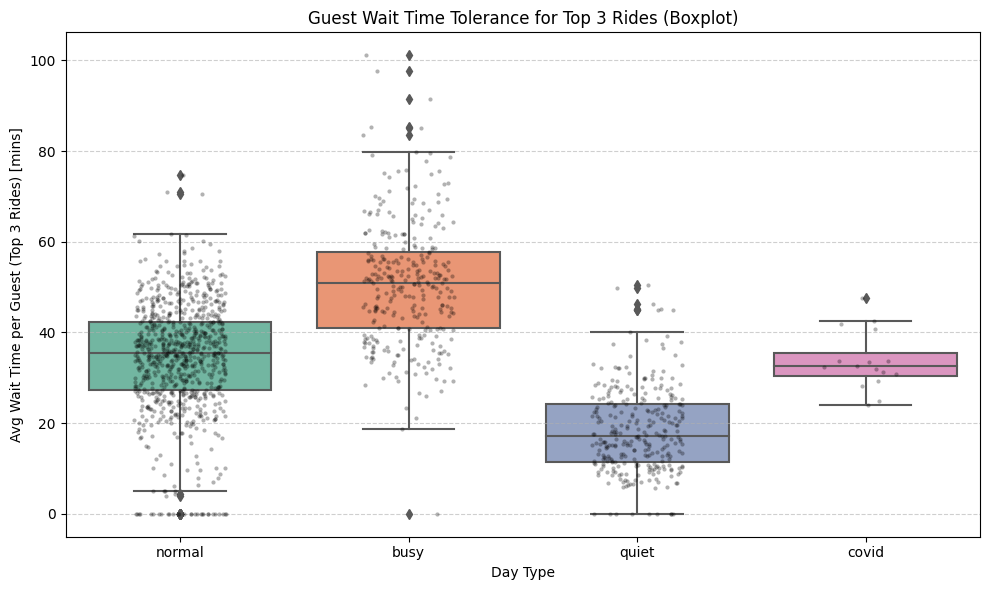

In [13]:
# Identify top 3 rides
top_rides = tivoli_g['ATTRACTION'].value_counts().nlargest(3).index.tolist()
avg_wait_top3 = guest_avg_wait_top_rides(tivoli_g, top_rides)
outflow_top3 = calculate_outflow_for_top_rides(tivoli_g, top_rides)
plot_combined_wait_and_outflow(avg_wait_top3, outflow_top3)

plot_avg_wait_boxplot(avg_wait_top3)

The line-bar plot shows that average wait times for the top 3 rides are highest on busy days and lowest on quiet days, while ride outflow (popularity) is highest on normal days. The boxplot reveals that although busy days have the longest waits, guest tolerance varies more widely, whereas quiet and covid days show more consistent, shorter waiting time. This suggests that guests show the highest willingness to wait for top rides during busy days, with average wait times peaking despite relatively lower guest outflow—suggesting that ride demand outweighs crowd dispersion. In contrast, normal days experience the highest guest outflow for top rides but slightly lower wait times, indicating better flow management. Quiet and COVID days show reduced wait time tolerance and guest flow, with tighter boxplots indicating more uniform experiences. This suggests that visitor patience and ride popularity are strongly linked to day type, with crowd levels shaping both ride selection and queue behavior.

### Express Pass vs. Non Express Pass Journeys

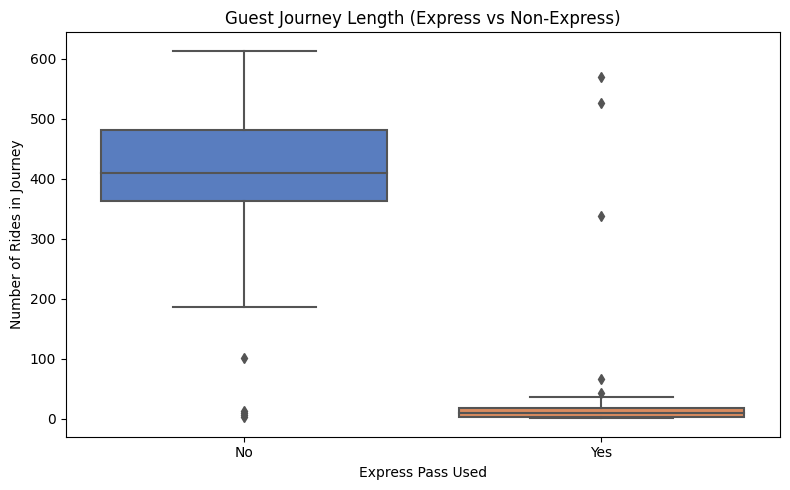

In [14]:
guest_summary = generate_guest_summary(tivoli_g)

guest_summary['SEQ_ENTROPY'] = guest_summary['RIDE_SEQUENCE'].apply(compute_sequence_entropy)
guest_summary['SEQ_LEN'] = guest_summary['RIDE_SEQUENCE'].apply(len)

plt.figure(figsize=(8, 5))
sns.boxplot(data=guest_summary, x='EXPRESS_PASS', y='SEQ_LEN', palette='muted')
plt.title("Guest Journey Length (Express vs Non-Express)")
plt.xlabel("Express Pass Used")
plt.ylabel("Number of Rides in Journey")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()

Guests that do not invest in Express Passes tend to have significantly longer ride journeys compared to those who do, as displayed by their high number of rides in journey. The distribution for non-Express guests shows a wide range and a higher median number of rides, suggesting they explore more of the park—possibly due to needing to plan more efficiently around wait times. In contrast, Express Pass users have much shorter ride sequences, potentially because they target specific high-priority rides, completing their intended experiences in less time. This implies Express Pass holders may optimize for convenience, while non-holders maximize park value through volume.

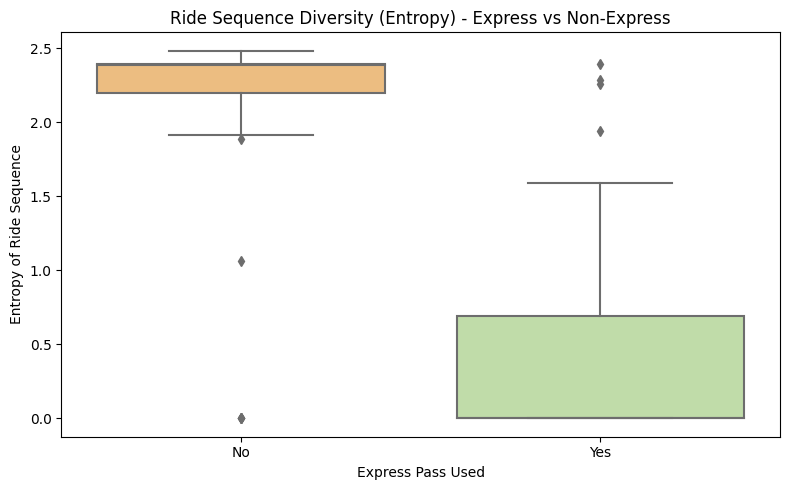

Avg similarity within Express journeys: 0.149
Avg similarity within Non-Express journeys: 0.001


In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=guest_summary, x='EXPRESS_PASS', y='SEQ_ENTROPY', palette='Spectral')
plt.title("Ride Sequence Diversity (Entropy) - Express vs Non-Express")
plt.xlabel("Express Pass Used")
plt.ylabel("Entropy of Ride Sequence")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()


# Quantifying the average similarities among express pass and non express pass users 
express_seqs = guest_summary[guest_summary['EXPRESS_PASS'] == True]['RIDE_SEQUENCE'].tolist()
nonexpress_seqs = guest_summary[guest_summary['EXPRESS_PASS'] == False]['RIDE_SEQUENCE'].tolist()
similarity_express = average_similarity(express_seqs)
similarity_nonexpress = average_similarity(nonexpress_seqs)
print(f"Avg similarity within Express journeys: {similarity_express:.3f}")
print(f"Avg similarity within Non-Express journeys: {similarity_nonexpress:.3f}")

Non-Express Pass users exhibit significantly higher ride sequence entropy, indicating a more diverse and varied ride experience throughout their visit. In contrast, Express Pass users tend to have lower entropy, suggesting they follow a more predictable or focused sequence—likely prioritizing specific popular rides without exploring much beyond. This implies that while Express Pass holders optimize for speed and efficiency, non-pass holders engage in more exploratory and varied park experiences. This is also supported by the average similarity scores of users with Express Passes and those without with a score of 0.149 and 0.001 respectively.

## Business Impacts and Recommendations

This analysis reveals clear behavioral patterns across different guest segments and day types. Express Pass users consistently experience shorter, more efficient journeys with higher ride sequence similarity, suggesting targeted ride strategies. In contrast, non-Express guests exhibit more diverse paths and longer wait times. On quiet days, both guest types display more exploratory behavior, while busy days constrain movement predictably toward high-throughout rides. This suggests that Express Pass usage directly enhances guest satisfaction and operational flow.

To act on these insights, several data-driven strategies are recommended. First, more express pass bundles could be promoted to encourage wider park exploration, particularly targeting youth groups, which are shown to benefit the most from reduced wait times. Second, implementing targeted crowd flow interventions—such as dynamic digital signage or time-based ride incentives—can help manage congestion by guiding guests to underutilized attractions. Lastly, using guest segmentation data to personalize promotions (e.g., offering family ride bundles or thrill-seeker express passes) based on actual guest journey behavior rather than just demographics can increase both relevance and conversion. Together, these measures will improve guest satisfaction, optimize ride utilization, and support more efficient park operations.